## Glucocorticoid receptor - part 4 (library enumeration)

### Import libraries

In [1]:
import pandas as pd

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import sys
sys.path.append('/home/daniel/wizepair2')
from mmpa.chem import strip_stereo

from rdkit import Chem

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read in the datasets

In [2]:
df = pd.read_csv('nr3c1_agonists_stripped.csv')
df_trans = pd.read_csv('nr3c1_agonists_transformations.csv')
df_holdout = pd.read_csv('nr3c1_agonists_stripped_holdout.csv')

### Take cortisol as only seed

In [3]:
df = df[df.stripped_smiles=='C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO']

### Merge on assay identifier to enumerate all seed molecule / transformation pairs

In [4]:
df = df[pd.notna(df.pchembl_value)]

### Apply the transformations

In [5]:
def apply_reaction(smiles, smirks):
    rxn = Chem.rdChemReactions.ReactionFromSmarts(smirks)
    productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(smiles)),))
    productlist = set()
    for product in productset:
        productlist.add('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
    return list(productlist)

In [6]:
def enumerate_recursive(df: pd.DataFrame(), df_trans: pd.DataFrame(), generations=1, hits=None):
    
    if generations > 0: 
    
        # merge with transformations and enumerate products
        print('Generations {}: inital frame - {}'.format(generations, len(df.index)))
        df_unique = df[['stripped_smiles', 'target_pref_name', 'standard_type']].drop_duplicates()
        print('Generations {}: deduped seeds / property pairs - {}'.format(generations, len(df_unique.index)))
        df_unique = df_unique.merge(df_trans, on=['target_pref_name', 'standard_type'])
        print('Generations {}: potential seed / transformation pairs - {}'.format(generations, len(df_unique.index)))
        df_product = df_unique.sample(frac=1).parallel_apply(lambda x: apply_reaction(x.stripped_smiles, x.smirks), axis=1)

        # fan out individual products
        df_product = df_unique.join(pd.DataFrame(df_product.explode(), columns=['products']))
        print('Generations {}: raw products - {}'.format(generations, len(df_product.index)))
        df_product = df_product[pd.notna(df_product.products)]
        print('Generations {}: non-null products - {}'.format(generations, len(df_product.index)))
        df_product = df.merge(df_product, on=['stripped_smiles', 'target_pref_name', 'standard_type'])
        print('Generations {}: final product / prediction pairs - {}'.format(generations, len(df_product.index)))

        # detect if target has been identified
        df_product['achiral_smiles'] = df_product.products.parallel_apply(strip_stereo)
        if df_product.achiral_smiles.isin(hits).any(): print('hit!')
                
        # trail tracking
        df_product['generation'] = generations
        if all(elem in df_product.columns for elem in ['last_smiles', 'min_pchembl_value', 'min_mean_percentmcs', 'max_radius']): 
            df_product.last_smiles = df_product.last_smiles + '.' + df_product.stripped_smiles
            df_product.min_pchembl_value = df_product[['min_pchembl_value', 'pchembl_value']].min(axis=1)
            df_product.min_mean_percentmcs = df_product[['min_mean_percentmcs', 'mean_percentmcs']].min(axis=1)
            df_product.max_radius = df_product[['max_radius', 'radius']].max(axis=1)
        else: 
            df_product['last_smiles'] = df_product.stripped_smiles
            df_product['min_pchembl_value'] = df_product.pchembl_value
            df_product['min_mean_percentmcs'] = df_product.mean_percentmcs
            df_product['max_radius'] = df_product.radius
            
        # update seed paramters
        df_product.stripped_smiles = df_product.products
        df_product.pchembl_value = df_product.pchembl_value + df_product.mean_pchembl_exact_delta
        
        # filter columns
        df_product = df_product[['generation', 'last_smiles', 'min_pchembl_value', 'min_mean_percentmcs', 'max_radius',
                                 'stripped_smiles', 'target_pref_name', 'standard_type', 'pchembl_value']]
        
        # filter rows
        df_product.drop_duplicates(inplace=True)

        # increment counter and yield
        generations -= 1
        yield df_product
        yield from enumerate_recursive(df_product, df_trans, generations, hits)


In [7]:
df_products = enumerate_recursive(df, df_trans, 4, df_holdout.achiral_smiles.unique())

In [8]:
df_products = pd.concat([x for x in df_products])

Generations 4: inital frame - 49
Generations 4: deduped seeds / property pairs - 20
Generations 4: potential seed / transformation pairs - 2080


Generations 4: raw products - 2103
Generations 4: non-null products - 159
Generations 4: final product / prediction pairs - 250


Generations 3: inital frame - 181
Generations 3: deduped seeds / property pairs - 105
Generations 3: potential seed / transformation pairs - 60979


Generations 3: raw products - 61171
Generations 3: non-null products - 3709
Generations 3: final product / prediction pairs - 6351


Generations 2: inital frame - 3379
Generations 2: deduped seeds / property pairs - 520
Generations 2: potential seed / transformation pairs - 275707


Generations 2: raw products - 276981
Generations 2: non-null products - 14916
Generations 2: final product / prediction pairs - 145189


Generations 1: inital frame - 71099
Generations 1: deduped seeds / property pairs - 2155
Generations 1: potential seed / transformation pairs - 898819


Generations 1: raw products - 906093
Generations 1: non-null products - 52794
Generations 1: final product / prediction pairs - 3275776


In [9]:
df_combined = df_holdout.merge(df_products, on=['stripped_smiles', 'target_pref_name', 'standard_type'], suffixes=['_actual', '_predicted'])

In [10]:
pd.pivot_table(df_combined, 
               values=['pchembl_value_actual', 'pchembl_value_predicted', 'min_mean_percentmcs'], 
               index=['generation', 'max_radius', 'stripped_smiles', 'target_pref_name', 'standard_type'], 
               aggfunc=['min', 'mean', 'max'])

generation,max_radius,stripped_smiles,target_pref_name,standard_type


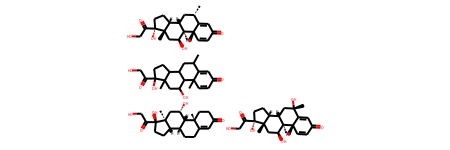

In [19]:
Chem.MolFromSmiles(df_products.sample(1).last_smiles.to_list()[0])

### Write to file

In [12]:
df_products = df_products.reset_index()
df_products.to_csv('nr3c1_agonists_products.csv', index=False)